<a href="https://colab.research.google.com/github/PranavMahajan25/Neural-ODE/blob/master/ODEnet_LatentSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cloning the repo, setting up the lib

In [0]:
!git clone https://github.com/rtqichen/torchdiffeq.git

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 124 (delta 5), reused 10 (delta 2), pack-reused 106
Receiving objects: 100% (124/124), 690.88 KiB | 1.22 MiB/s, done.
Resolving deltas: 100% (45/45), done.
fatal: destination path 'torchdiffeq' already exists and is not an empty directory.


In [0]:
!cd torchdiffeq && pip install -e .

Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq


In [0]:
!ls torchdiffeq/torchdiffeq

_impl  __init__.py


In [0]:
#!python torchdiffeq/examples/latent_ode.py 

#Preliminaries, importing, intialising ODE and solving it for real Y values

In [0]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def generate_spiral2d(nspiral=1000,
                      ntotal=500,
                      nsample=100,
                      start=0.,
                      stop=1,  # approximately equal to 6pi
                      noise_std=.1,
                      a=0.,
                      b=1.,
                      savefig=True):
    """Parametric formula for 2d spiral is `r = a + b * theta`.
    Args:
      nspiral: number of spirals, i.e. batch dimension
      ntotal: total number of datapoints per spiral
      nsample: number of sampled datapoints for model fitting per spiral
      start: spiral starting theta value
      stop: spiral ending theta value
      noise_std: observation noise standard deviation
      a, b: parameters of the Archimedean spiral
      savefig: plot the ground truth for sanity check
    Returns: 
      Tuple where first element is true trajectory of size (nspiral, ntotal, 2),
      second element is noisy observations of size (nspiral, nsample, 2),
      third element is timestamps of size (ntotal,),
      and fourth element is timestamps of size (nsample,)
    """

    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]

    # generate clock-wise and counter clock-wise spirals in observation space
    # with two sets of time-invariant latent dynamics
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs, ys = rs_cw * np.cos(zs_cw) - 5., rs_cw * np.sin(zs_cw)
    orig_traj_cw = np.stack((xs, ys), axis=1)

    zs_cc = orig_ts
    rw_cc = a + b * zs_cc
    xs, ys = rw_cc * np.cos(zs_cc) + 5., rw_cc * np.sin(zs_cc)
    orig_traj_cc = np.stack((xs, ys), axis=1)

    if savefig:
        plt.figure()
        plt.plot(orig_traj_cw[:, 0], orig_traj_cw[:, 1], label='clock')
        plt.plot(orig_traj_cc[:, 0], orig_traj_cc[:, 1], label='counter clock')
        plt.legend()
        plt.savefig('./ground_truth.png', dpi=500)
        print('Saved ground truth spiral at {}'.format('./ground_truth.png'))

    # sample starting timestamps
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        # don't sample t0 very near the start or the end
        t0_idx = npr.multinomial(
            1, [1. / (ntotal - 2. * nsample)] * (ntotal - int(2 * nsample)))
        t0_idx = np.argmax(t0_idx) + nsample

        cc = bool(npr.rand() > .5)  # uniformly select rotation
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)

        samp_traj = orig_traj[t0_idx:t0_idx + nsample, :].copy()
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)

    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)

    return orig_trajs, samp_trajs, orig_ts, samp_ts

Saved ground truth spiral at ./ground_truth.png
1000 1000 1000 100


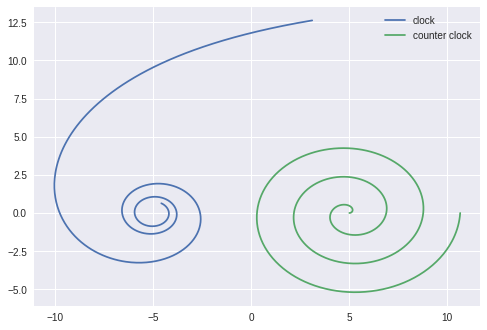

In [0]:
# generate toy spiral data
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(nspiral=1000,
        start=0.,
        stop=6 * np.pi,
        noise_std=.3,
        a=0., b=.3, ntotal = 1000, nsample = 100)
print(len(orig_trajs), len(samp_trajs), len(orig_ts), len(samp_ts))

In [0]:

print(len(samp_trajs[0,:,:])) # total dataset size of spirals is 1000 spirals but each sampled spiral has 100 datapoints
print(samp_trajs[0,0,:])

100
[6.39077874 4.36982701]


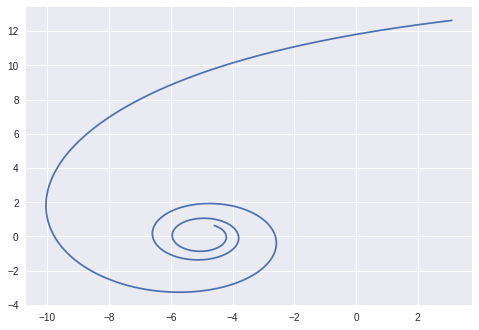

In [0]:
plt.plot(orig_trajs[9,:, 0], orig_trajs[9,:, 1], label='sampled') #1000 datapoints

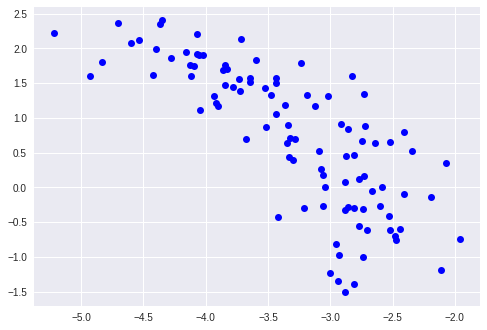

In [0]:
plt.plot(samp_trajs[9,:, 0], samp_trajs[9,:, 1],'bo', label='sampled') #100 data points, some random subset of orig_trajs with noise added

# ODEnet vs RNN , both will output latent state and then we'll use the same decoder for both

In [0]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)   # outputs latent state of dim 4
        self.nfe = 0

    def forward(self, t, x): # Note that forward pass has time t as input as well, as compared to RNN where the argument would be no. of neurons in hidden layers!
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


In [0]:
class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2) # Note that we are outputing twice the size of latent dim, this will go in as qz0_mean and qz0_logvar ... see training loop

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

In [0]:
class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [0]:
#same func as in last colab, we'll use this in training to calculate and show loss
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


# Let's train

In [0]:
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100

Saved ground truth spiral at ./ground_truth.png


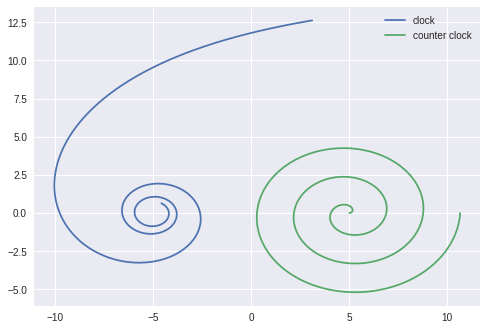

In [0]:
# generate toy spiral data like before
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(
        nspiral=nspiral,
        start=start,
        stop=stop,
        noise_std=noise_std,
        a=a, b=b
    )
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

In [0]:
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)

In [0]:
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
#params

In [0]:
optimizer = optim.Adam(params, lr=0.01)
loss_meter = RunningAverageMeter()

In [0]:
#playing with functions in training loop
print(samp_trajs.size())
print(samp_trajs.size(1)) # total dataset size of spirals is 1000 spirals but each sampled spiral has 100 datapoints

h = rec.initHidden().to(device) # for recurrent nn
for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h) # init forward pass to start rnn

print(out.size(),h.size()) #weights

qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

print('z0 size = ', z0.size())
pred_z = odeint(func, z0, samp_ts)
print('pred_z size = ', pred_z.size())
pred_z = pred_z.permute(1, 0, 2)
print('pred_z size after changing axes = ',pred_z.size())
pred_x = dec(pred_z)
print('pred_x size = ',pred_x.size())

torch.Size([1000, 100, 2])
100
torch.Size([1000, 8]) torch.Size([1000, 25])
z0 size =  torch.Size([1000, 4])
pred_z size =  torch.Size([100, 1000, 4])
pred_z size after changing axes =  torch.Size([1000, 100, 4])
pred_x size =  torch.Size([1000, 100, 2])


In [0]:
def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

In [0]:
def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

In [0]:
train_dir='./'

In [0]:
niters=2000
for itr in range(1, niters+1):
    optimizer.zero_grad()
    # backward in time to infer q(z_0)
    h = rec.initHidden().to(device) # for recurrent nn
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h) # init forward pass to create batch_y0 for training
        
        
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    
    
    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)  #decoder
    
    # compute loss
    noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
    noise_logvar = 2. * torch.log(noise_std_).to(device)
    logpx = log_normal_pdf(samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
    pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
    analytic_kl = normal_kl(qz0_mean, qz0_logvar,pz0_mean, pz0_logvar).sum(-1)
    loss = torch.mean(-logpx + analytic_kl, dim=0)
    
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())
    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))
    

Iter: 1, running avg elbo: -19221.3418
Iter: 2, running avg elbo: -19213.7773
Iter: 3, running avg elbo: -19195.7736
Iter: 4, running avg elbo: -19158.0419
Iter: 5, running avg elbo: -19097.0317
Iter: 6, running avg elbo: -19013.7749
Iter: 7, running avg elbo: -18922.0761
Iter: 8, running avg elbo: -18821.0912
Iter: 9, running avg elbo: -18715.4176
Iter: 10, running avg elbo: -18608.5221
Iter: 11, running avg elbo: -18499.5063
Iter: 12, running avg elbo: -18388.3900
Iter: 13, running avg elbo: -18275.8631
Iter: 14, running avg elbo: -18161.2729
Iter: 15, running avg elbo: -18045.1208
Iter: 16, running avg elbo: -17927.1146
Iter: 17, running avg elbo: -17808.5018
Iter: 18, running avg elbo: -17690.1068
Iter: 19, running avg elbo: -17573.2220
Iter: 20, running avg elbo: -17457.4501
Iter: 21, running avg elbo: -17342.3445
Iter: 22, running avg elbo: -17226.9509
Iter: 23, running avg elbo: -17111.6394
Iter: 24, running avg elbo: -16996.2433
Iter: 25, running avg elbo: -16881.4757
Iter: 26,

In [0]:
pred_x.size()

torch.Size([1000, 100, 2])

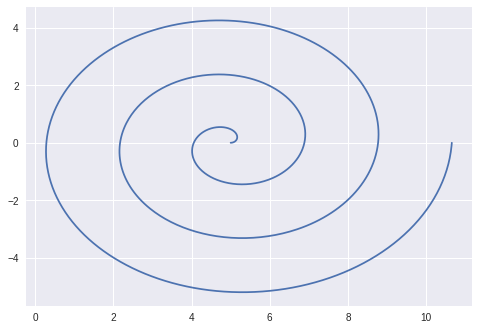

In [0]:
plt.plot(orig_trajs[1,:, 0], orig_trajs[1,:, 1], label='sampled') #1000 datapoints

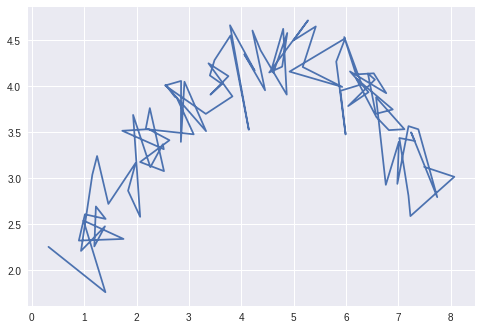

In [0]:
plt.plot(samp_trajs[1,:, 0], samp_trajs[1,:, 1], label='sampled') #1000 datapoints

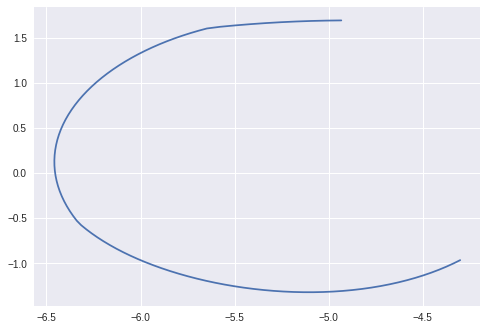

In [0]:
plt.plot(pred_x[1,:, 0].detach().numpy(), pred_x[1,:, 1].detach().numpy(), label='sampled') #1000 datapoints 
# actually jumbled, will need to write a forward pass to get actual values